In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import xarray as xr
from scipy import ndimage
import cv2 as cv

lon   x   y        lat       B01       B02       B03  \
n                                                                             
2018-06-07 0     26.564011   0   0  39.109287       NaN       NaN       NaN   
           1     26.564127   1   0  39.109287       NaN       NaN       NaN   
           2     26.564241   2   0  39.109287       NaN       NaN       NaN   
           3     26.564358   3   0  39.109291       NaN       NaN       NaN   
           4     26.564474   4   0  39.109291       NaN       NaN       NaN   
...                    ...  ..  ..        ...       ...       ...       ...   
2019-06-07 1003  26.568302  19  41  39.107231  0.036926  0.035275  0.030083   
           1004  26.568419  20  41  39.107231  0.037197  0.037299  0.032572   
           1005  26.568535  21  41  39.107231  0.037197  0.037173  0.031452   
           1006  26.568649  22  41  39.107231  0.037197  0.036793  0.030208   
           1007  26.568766  23  41  39.107235  0.037197  0.036667  0.029959   

                      B04       B05       B06       B07       B08      B08A  \
n                                                                             
2018-06-07 0          NaN       NaN       NaN       NaN       NaN       NaN   
           1          NaN       NaN       NaN       NaN       NaN       NaN   
           2          NaN       NaN       NaN       NaN       NaN       NaN   
           3          NaN       NaN       NaN       NaN       NaN       NaN   
           4          NaN       NaN       NaN       NaN       NaN       NaN   
...                   ...       ...       ...       ...       ...       ...   
2019-06-07 1003  0.022997  0.022115  0.024495  0.025049  0.021762  0.024173   
           1004  0.023799  0.021659  0.024382  0.024723  0.024465  0.022685   
           1005  0.022882  0.021659  0.024382  0.024723  0.023451  0.022685   
           1006  0.022080  0.020402  0.022686  0.023311  0.022437  0.022792   
           1007  0.022080  0.020402  0.022686  0.023311  0.022437  0.022792   

                      B11       B12  label   distance  
n                                                      
2018-06-07 0          NaN       NaN    0.0   0.000000  
           1          NaN       NaN    0.0   0.000000  
           2          NaN       NaN    0.0   0.000000  
           3          NaN       NaN    0.0   0.000000  
           4          NaN       NaN    0.0   0.000000  
...                   ...       ...    ...        ...  
2019-06-07 1003  0.019884  0.017037    0.0  28.425341  
           1004  0.019473  0.016931    0.0  29.206164  
           1005  0.019473  0.016931    0.0  30.000000  
           1006  0.019473  0.016399    0.0  30.805844  
           1007  0.019473  0.016399    0.0  31.622777  

[6048 rows x 17 columns]

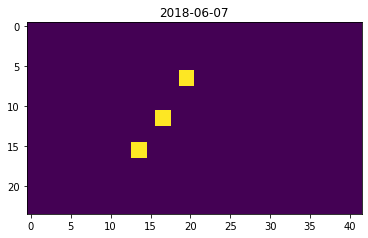

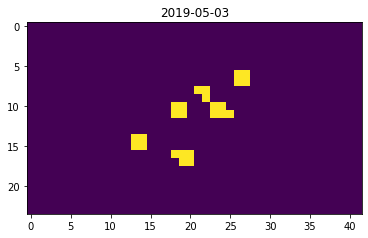

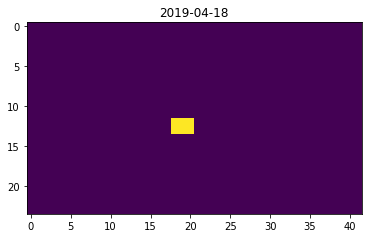

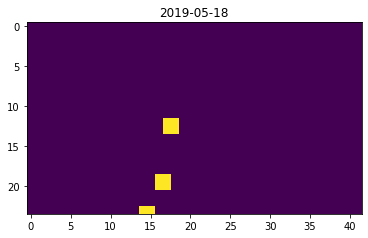

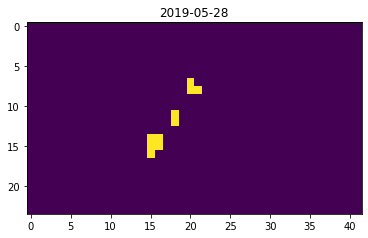

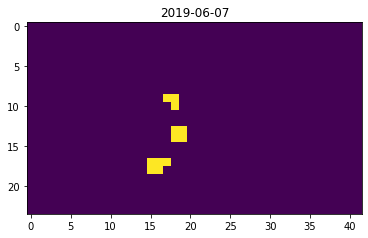

In [10]:
def load_data_set():
    cwd = os.getcwd()
    path=os.path.join(os.path.split(cwd)[0],"dataset\\PLP2019\\S2_satellite_images_nc\\")

        
    #path=os.path.abspath('C:/Users/lavra/Documents/imt_atlantique_2A/projet_s4b2/datas/S2_satellite_images_nc')
    liste_fichier=os.listdir(path)
    data=[]
    for i,fichier in enumerate(liste_fichier):
        to_open=os.path.join(path,fichier)
        data.append(Dataset(to_open))

    config={'lon':'lon','lat':'lat','rhow_442' : 'B01', 'rhow_492' : 'B02', 'rhow_559' : 'B03', 'rhow_665':'B04', 'rhow_704':'B05', 'rhow_739':'B06', 'rhow_780':'B07', 'rhow_833':'B08', 'rhow_864':'B08A', 'rhow_1610':'B11', 'rhow_2186':'B12','rhow_443' : 'B01', 'rhow_492' : 'B02', 'rhow_560' : 'B03', 'rhow_740' : 'B06', 'rhow_783':'B07',  'rhow_865':'B08A', 'rhow_1614':'B11', 'rhow_2202':'B12'}
#sert a prevenir le fait que les satellite n'ont pas exactement la meme valeur de longeur d'onde detecté

    multi_data=pd.DataFrame()


    for i,netcdf_fichier in enumerate(data):
    
        data_frame=pd.DataFrame()
        
        for nom_variable in netcdf_fichier.variables.keys():

            if("rhow" in nom_variable or "lon" in nom_variable or "lat" in nom_variable):
                #d["size"]=numpy_array.shape
                numpy_array=netcdf_fichier["/"+nom_variable][:,:]
                #print(numpy_array)
                shape=numpy_array.shape
                numpy_array=numpy_array.flatten()
                x,y= np.meshgrid(range(shape[0]), range(shape[1]))
                x=x.flatten()
                y=y.flatten()
                data_frame[config[nom_variable]]=numpy_array
                data_frame["x"]=x
                data_frame["y"]=y
                #d[config[nom_variable]]=numpy_array.flatten()
        multi_data=multi_data.append(data_frame.assign(n=netcdf_fichier.isodate[0:10]).set_index('n',append=True).swaplevel(0,1))

    for index in multi_data.index.unique(level=0):#pas d'info sur la photo de 2018

        folder_name=index.replace("-","")
        path=os.path.join(os.path.split(cwd)[0],"dataset\\PLP2019\\Vector_Points\\"+folder_name+r"\\Excel Values\\")
        #
        # 
        # path=r"datas/Vector_Points/"+folder_name+r"/Excel Values/"
        excel_name=os.listdir(path)[0]
        excel=pd.read_excel(path+excel_name)
        x_range=netcdf_fichier.xrange
        size_x=int((x_range.max()-x_range.min())/10)
        y_range=netcdf_fichier.yrange
        size_y=int((y_range.max()-y_range.min())/10)

        labels=np.zeros((size_y,size_x))
        for i,j in zip(excel["POINT_X"],excel["POINT_Y"]):
            #les zones des pixels sont approximatifs

            x,y=(i-x_range.min())/10,(j-y_range.min())/10
            if x>=0 and y>=0 and x<size_x and y<size_y:
                x,y=int(x),int(y)
                #print(index+"  ",x,(j-y_range.min())/10)
                labels[size_y-1-y,x]+=1
            
            
            
        #np.save("label-"+str(index),labels)
        plt.figure()
        plt.title(index)
        plt.imshow(labels)
        
        multi_data.loc[index,"label"]=labels.flatten()
    shape=(len(multi_data.x.unique()),len(multi_data.y.unique()))
    for date in multi_data.index.unique(level=0)[0:]:
            
        terre=np.array(multi_data.loc[date]["B01"].isna()).reshape(shape)#quand B01 est NAN, on est sur la terre
        terre=1-terre*1
        terre=ndimage.distance_transform_edt(terre)
        
        multi_data.loc[date,"distance"]=terre.flatten()
    return multi_data



data=load_data_set()
data

In [11]:
def plot_image(data_frame,arguments=["B04","B03","B02"],normalize=-1,alpha=-1,cmap="rainbow"):#normalize donne la valeur pour normaliser. si non donnée ou inf à 0, on prend le max de l'image
    shape=(len(data_frame.x.unique()),len(data_frame.y.unique()),len(arguments))
    to_plot=np.array(data_frame[arguments]).reshape(shape)
   
    
    if normalize<0:
        
        if np.any(np.isfinite(to_plot)):#si au moins une des valeurs est de valeur fini
            normalize=np.nanmax(to_plot)
        else:
            print("pas de donnée pour cette image")
            return None#pas la peine d'afficher

    if alpha>=0:#si on utilise le parametre alpha -> on est sur l'image avec le label=1
        alphas=alpha*to_plot[:,:,0]
        print(alphas.shape)
    else:
        alphas=1.
   
    to_plot=np.array(to_plot/normalize)#normalize the luminosity

    plt.imshow(to_plot,alpha=alphas,cmap=cmap)


2018-06-07
[[0.03695347 0.02726369 0.02919608 0.02753092]
 [0.018      0.023      0.035      0.062     ]
 [0.11       0.045      0.033      0.039     ]]
2019-05-03
[[0.03795856 0.02476785 0.02391061 0.02213042]
 [0.018      0.023      0.035      0.062     ]
 [0.11       0.045      0.033      0.039     ]]
2019-04-18
[[0.03673334 0.01926356 0.01801022 0.00971881]
 [0.018      0.023      0.035      0.062     ]
 [0.11       0.045      0.033      0.039     ]]
2019-05-18
[[0.07863718 0.05514664 0.05307241 0.02895919]
 [0.018      0.023      0.035      0.062     ]
 [0.11       0.045      0.033      0.039     ]]
2019-05-28
[[0.02962056 0.0402138  0.05802474 0.0546821 ]
 [0.018      0.023      0.035      0.062     ]
 [0.11       0.045      0.033      0.039     ]]
2019-06-07
[[0.03673245 0.02315287 0.02201601 0.02095971]
 [0.018      0.023      0.035      0.062     ]
 [0.11       0.045      0.033      0.039     ]]
<ipython-input-12-ccef2cf4b139>:17: RuntimeWarning: More than 20 figures have been

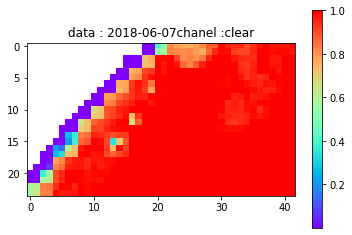

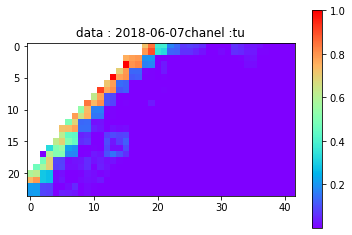

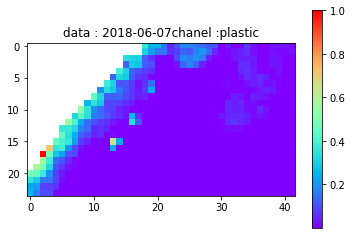

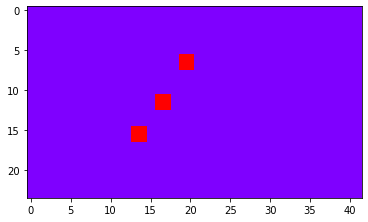

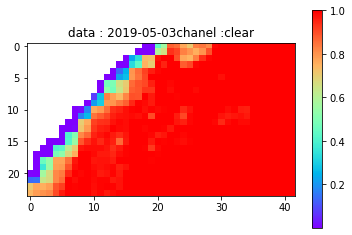

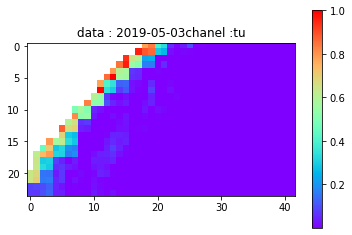

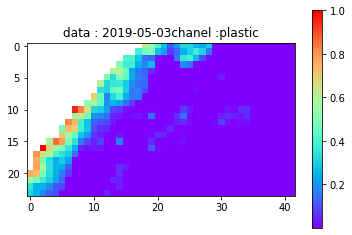

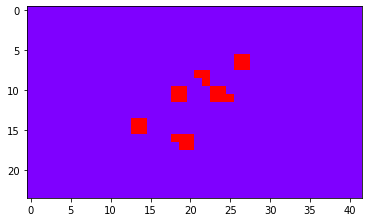

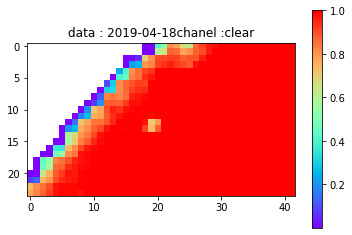

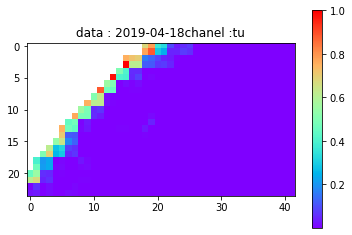

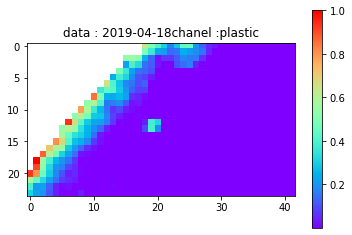

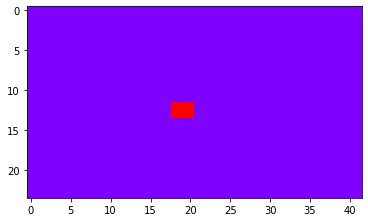

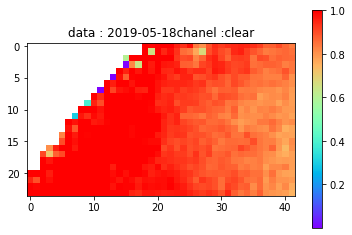

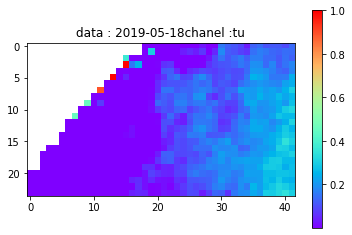

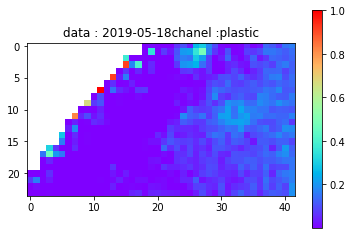

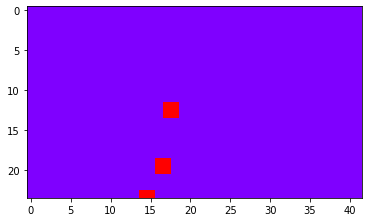

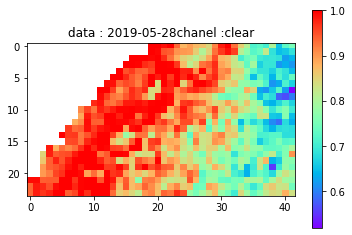

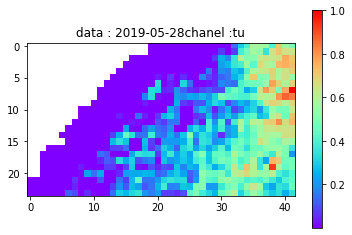

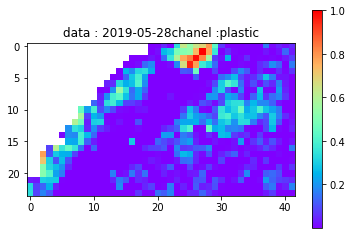

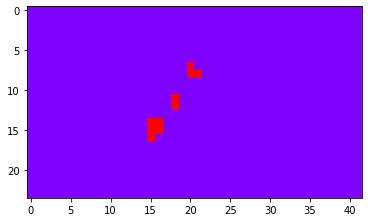

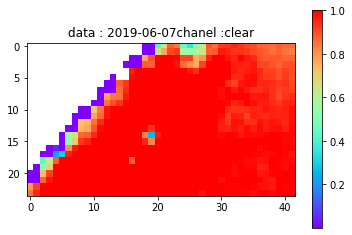

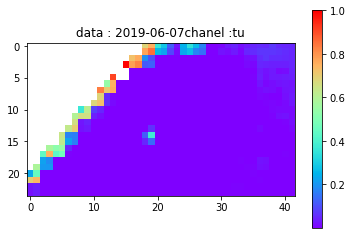

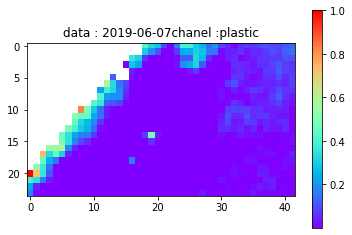

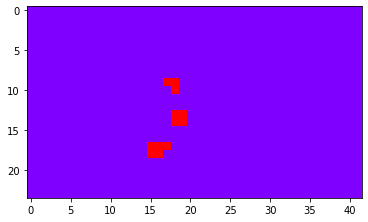

In [12]:
from pysptools.abundance_maps.amaps import FCLS
dic={0:"clear",1:"tu",2:"plastic"}
for i in data.index.unique(level=0):

    print(i)

    image=data.loc[i]

    target=image[["B02","B04","B08","B11"]].dropna()
    
    #spectral_sign=np.array([np.array(target.mean()),[0.018,0.023,0.035,0.062],[ 0.051, 0.045, 0.033, 0.039]])
    spectral_sign=np.array([np.array(target.mean()),[0.018,0.023,0.035,0.062],[ 0.11, 0.045, 0.033, 0.039]])
    print(spectral_sign)
    resultat=FCLS(np.array(target),spectral_sign)
    for k in range(resultat.shape[1]):
            
        plt.figure()
        plt.title("data : "+str(i)+"chanel :"+dic[k])
        data.loc[i,"prediction"]=np.array(pd.Series(resultat[:,k],index=target.index).reindex(image.index))
        plot_image(data.loc[i],arguments=["prediction"])
        plt.colorbar()
    plt.figure()
    plot_image(data.loc[i],arguments=["label"])
    

2018-06-07
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
2019-05-03
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
2019-04-18
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
2019-05-18
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
2019-05-28
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
2019-06-07
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
<ipython-input-38-fbe279a7c385>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warn

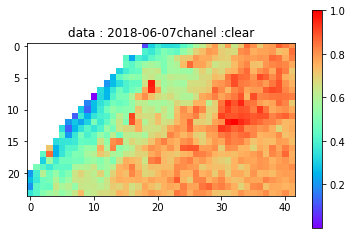

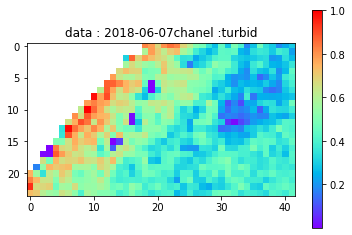

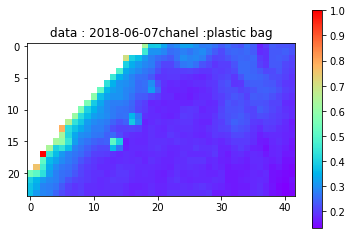

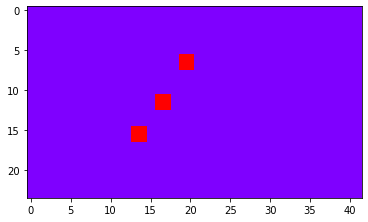

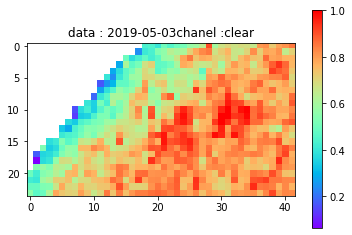

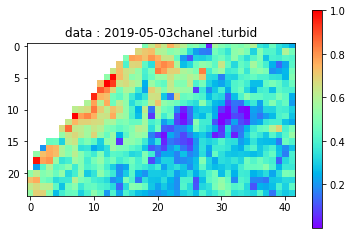

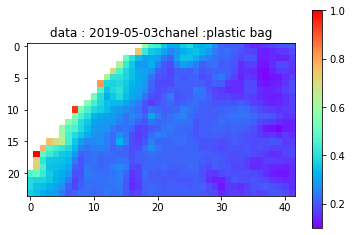

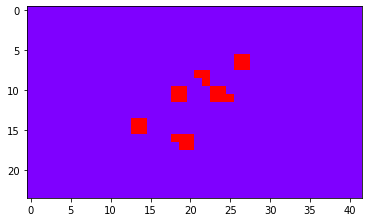

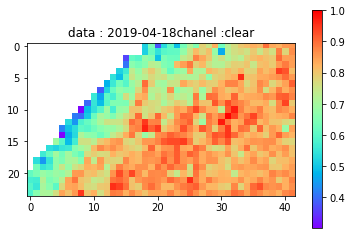

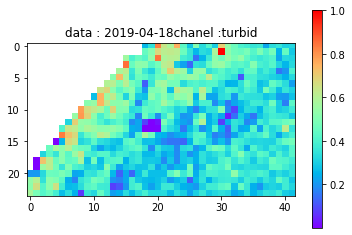

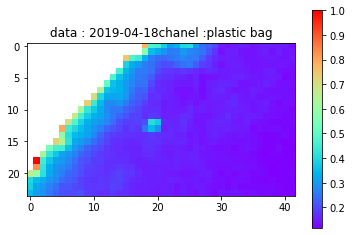

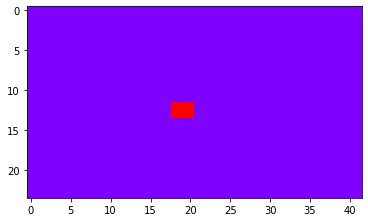

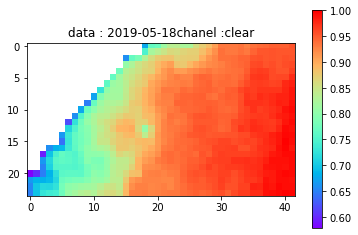

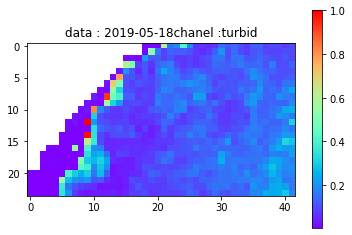

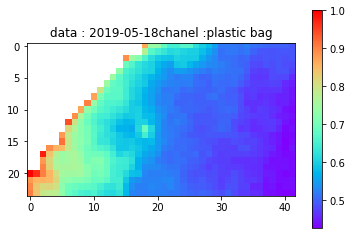

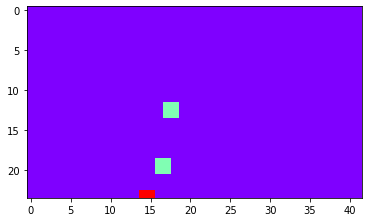

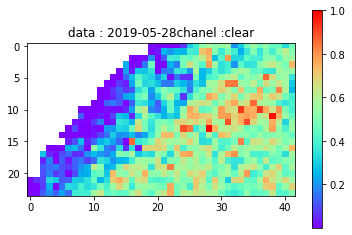

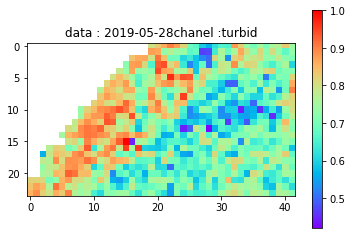

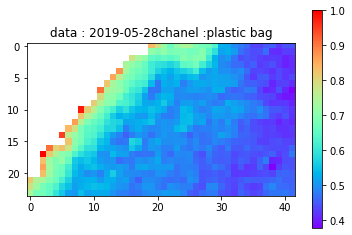

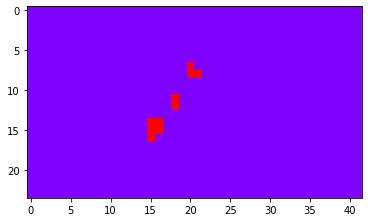

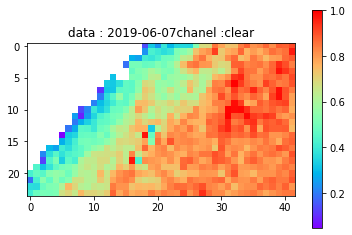

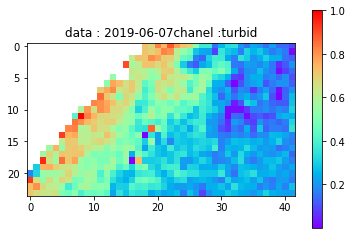

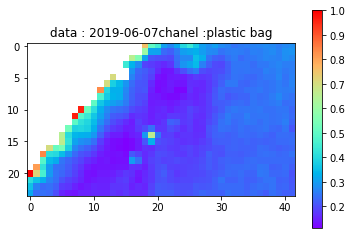

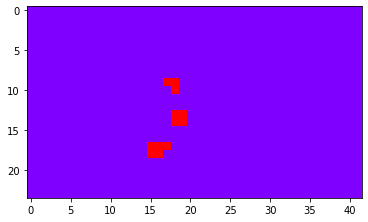

In [38]:
from pysptools.abundance_maps.amaps import FCLS
dic={0:"clear",1:"turbid",2:"plastic bag"}
for i in data.index.unique(level=0):

    print(i)

    image=data.loc[i]

    target=image[["B02","B03","B04","B08"]].dropna()
    
    spectral_sign=np.array([[0.028,0.006,0.001,0.0001],[0.007,0.018,0.011,0.001],[ 0.1, 0.13, 0.19,0.23]])
    print(spectral_sign)
    resultat=FCLS(np.array(target),spectral_sign)
    for k in range(resultat.shape[1]):
            
        plt.figure()
        plt.title("data : "+str(i)+"chanel :"+dic[k])
        data.loc[i,"prediction"]=np.array(pd.Series(resultat[:,k],index=target.index).reindex(image.index))
  
        plot_image(data.loc[i],arguments=["prediction"])
        plt.colorbar()
    plt.figure()
    plot_image(data.loc[i],arguments=["label"])

    

2018-06-07
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
2019-05-03
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
2019-04-18
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
2019-05-18
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
2019-05-28
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
2019-06-07
[[2.8e-02 6.0e-03 1.0e-03 1.0e-04]
 [7.0e-03 1.8e-02 1.1e-02 1.0e-03]
 [1.0e-01 1.3e-01 1.9e-01 2.3e-01]]
<ipython-input-130-a241a73a6181>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_war

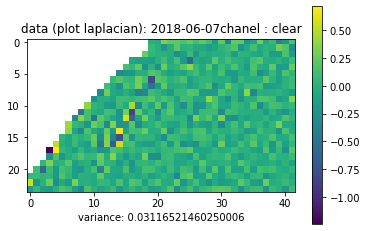

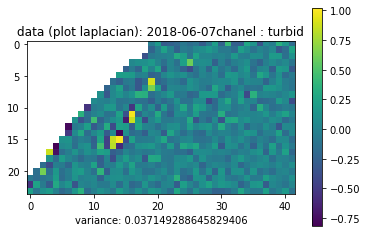

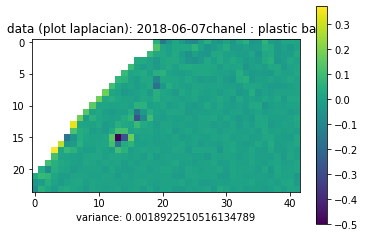

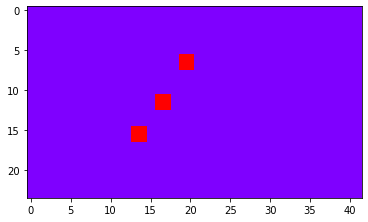

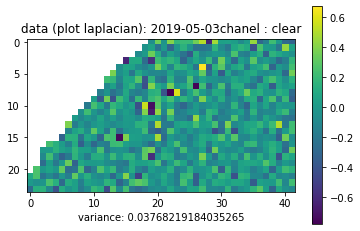

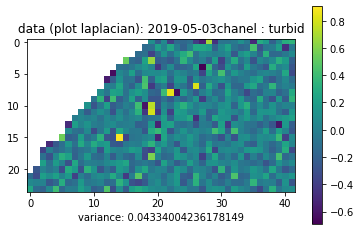

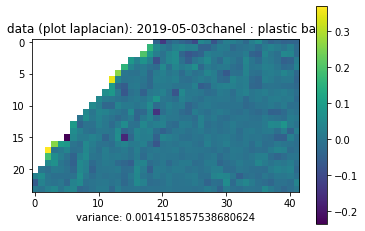

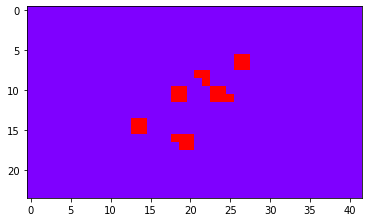

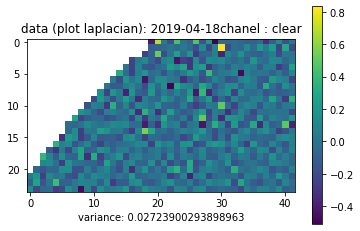

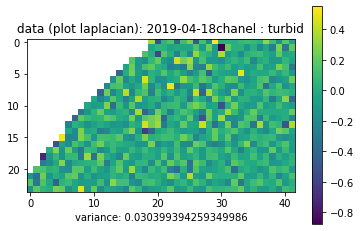

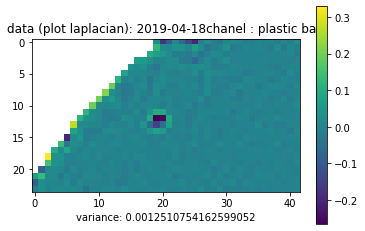

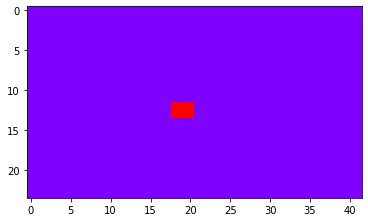

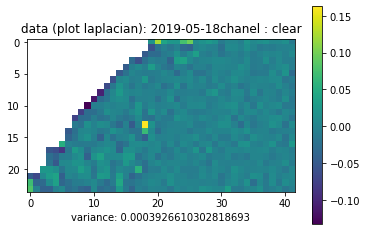

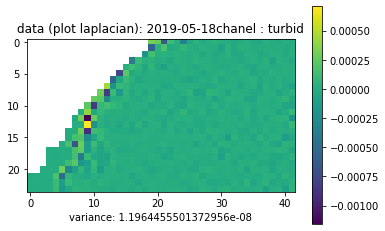

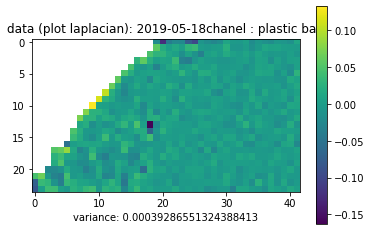

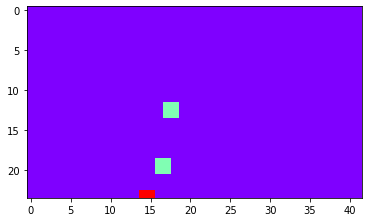

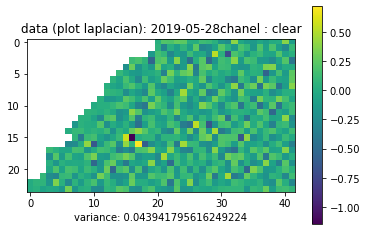

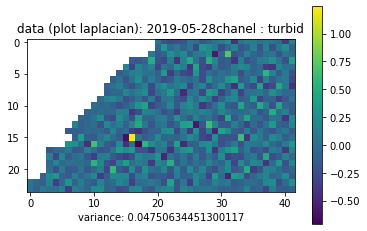

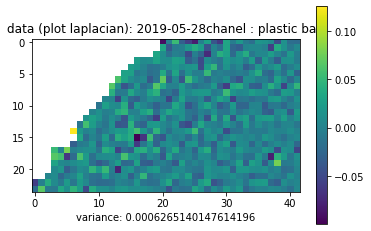

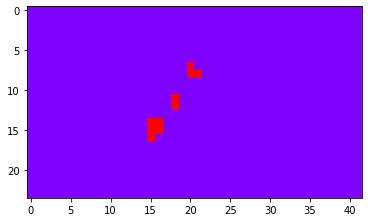

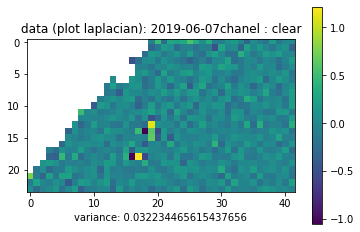

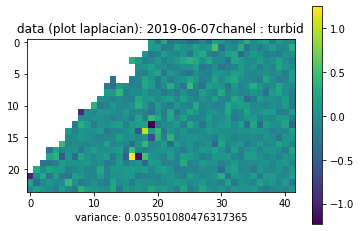

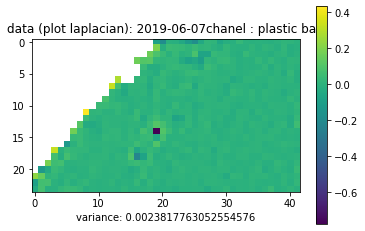

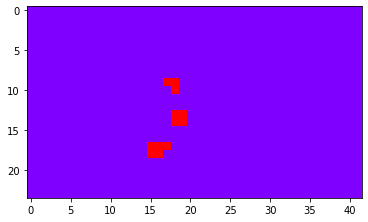

In [130]:
from pysptools.abundance_maps.amaps import FCLS
dic={0:"clear",1:"turbid",2:"plastic bag",3:"algues (Sargassum)"}
shape=(len(data.x.unique()),len(data.y.unique()))
for i in data.index.unique(level=0):

    print(i)

    image=data.loc[i]

    target=image[["B02","B03","B04","B08"]].dropna()
    spectral_sign=np.array([[0.028,0.006,0.001,0.0001],[0.007,0.018,0.011,0.001],[ 0.1, 0.13, 0.19,0.23]])
    #spectral_sign=np.array([[0.028,0.006,0.001,0.0001],[0.007,0.018,0.011,0.001],[ 0.1, 0.13, 0.19,0.23],[0.025,0.07,0.06,0.021]])
    
    print(spectral_sign)
    resultat=FCLS(np.array(target),spectral_sign)
    for k in range(resultat.shape[1]):
            
        plt.figure()
        plt.title("data (plot laplacian): "+str(i)+"chanel : "+dic[k])
        data.loc[i,"prediction"]=np.array(pd.Series(resultat[:,k],index=target.index).reindex(image.index))
        im_pred=np.array(data.loc[i]["prediction"]).reshape(shape).astype(np.float64)
        
        dst = cv.Laplacian(im_pred, -1)
        variance=np.var(dst[np.logical_not(np.isnan(dst))])
        #plt.imshow(im_pred)#voir complementarité turbid/ clear
        plt.imshow(dst)


        plt.xlabel("variance: "+str(variance))
        plt.colorbar()
    plt.figure()
    plot_image(data.loc[i],arguments=["label"])

2018-06-07
[[2.80000000e-02 6.00000000e-03 1.00000000e-03 1.00000000e-04]
 [7.00000000e-03 1.80000000e-02 1.10000000e-02 9.00000000e-04]
 [3.69534679e-02 3.88497412e-02 2.72636879e-02 2.91960817e-02]
 [1.00000000e-01 1.30000000e-01 1.90000000e-01 2.30000000e-01]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2019-05-03
[[2.80000000e-02 6.00000000e-03 1.00000000e-03 1.00000000e-04]
 [7.00000000e-03 1.80000000e-02 1.10000000e-02 9.00000000e-04]
 [3.79585624e-02 3.73408906e-02 2.47678477e-02 2.39106081e-02]
 [1.00000000e-01 1.30000000e-01 1.90000000e-01 2.30000000e-01]]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2019-04-18
[[2.80000000e-02 6.00000000e-03 1.00000000e-03 1.00000000e-04]
 [7.00000000e-03 1.80000000e-02 1.10000000e-02 9.00000000e-04]
 [3.6

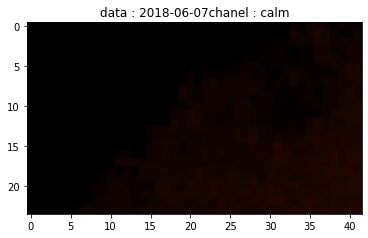

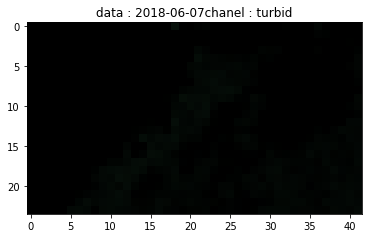

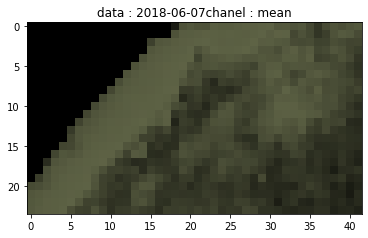

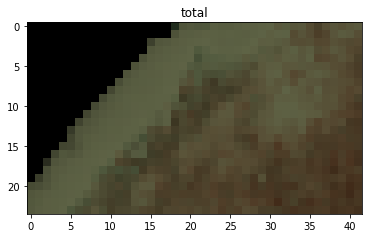

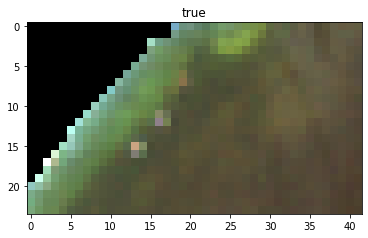

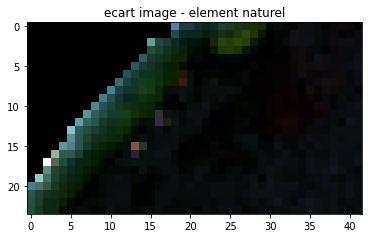

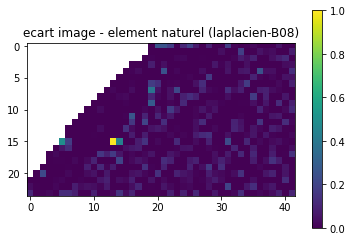

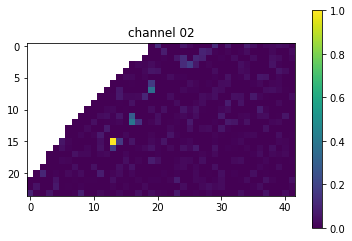

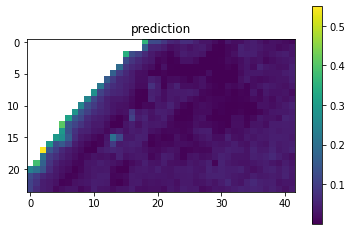

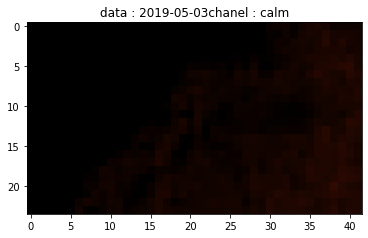

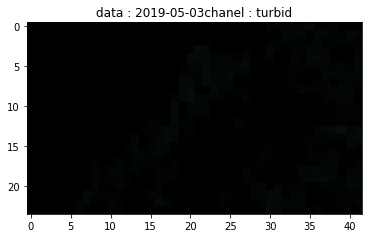

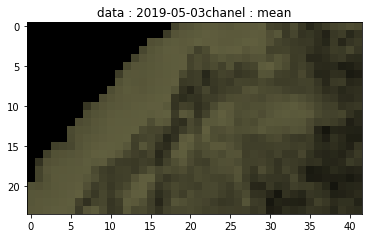

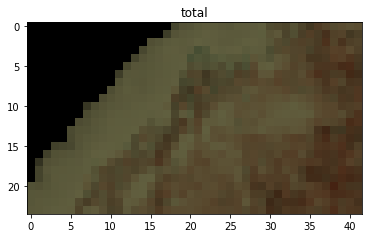

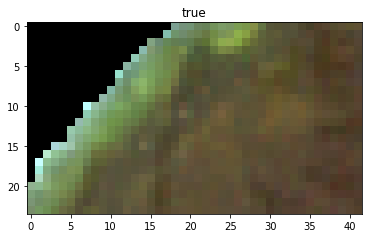

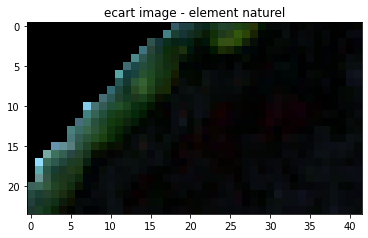

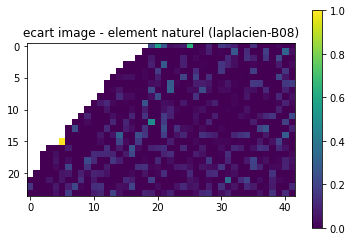

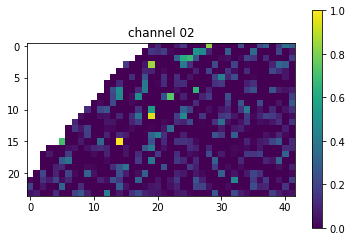

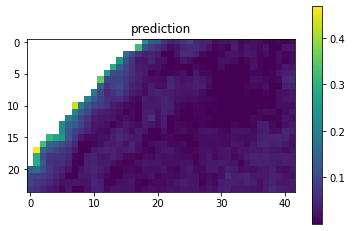

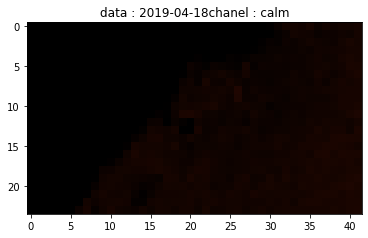

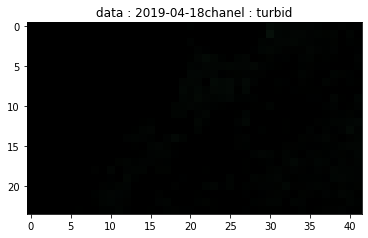

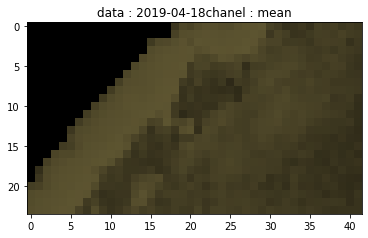

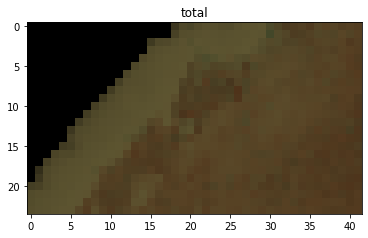

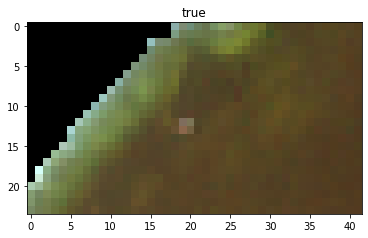

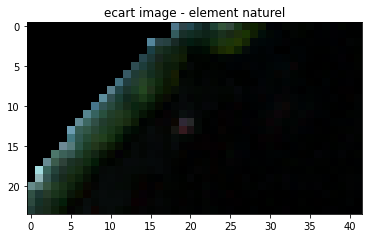

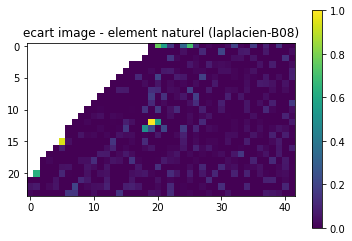

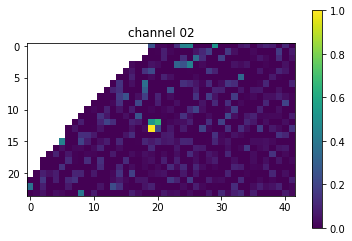

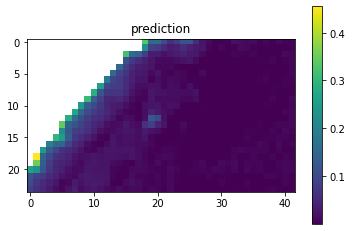

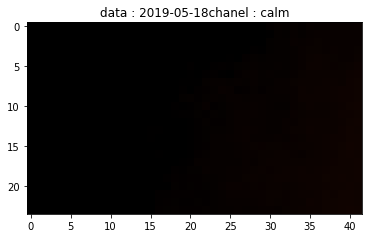

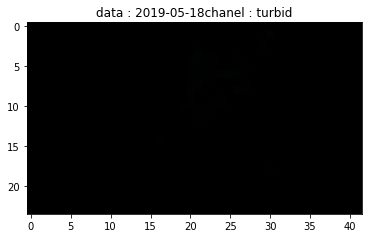

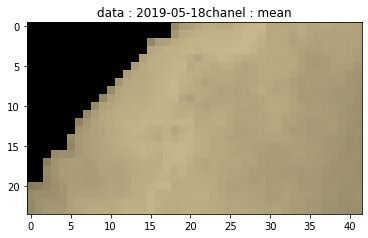

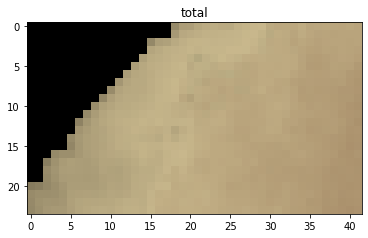

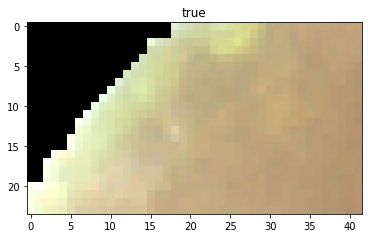

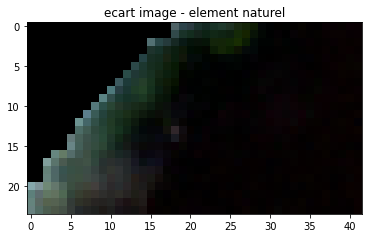

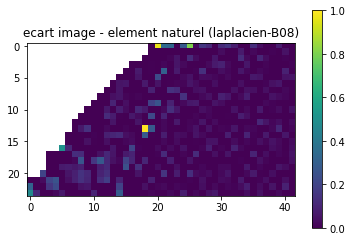

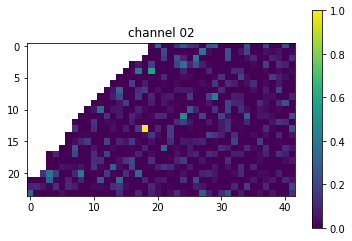

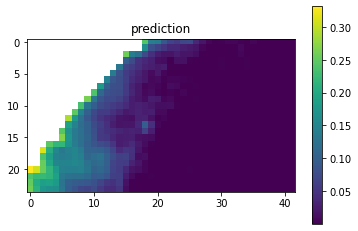

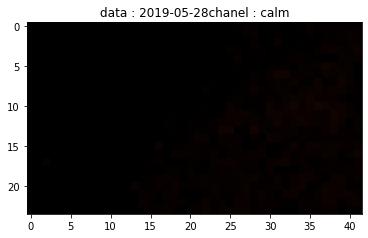

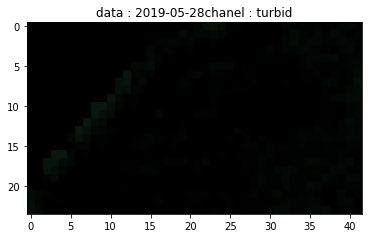

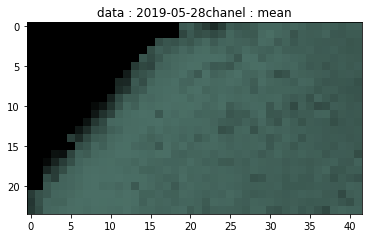

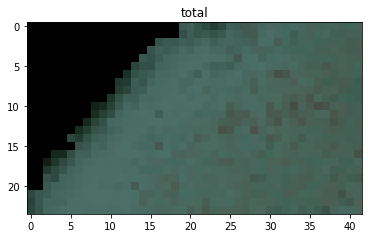

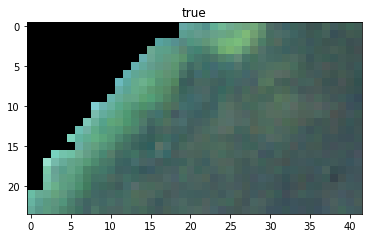

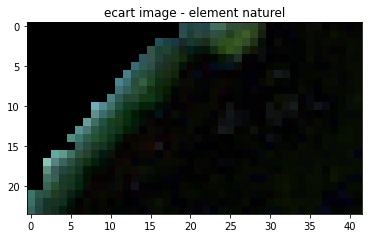

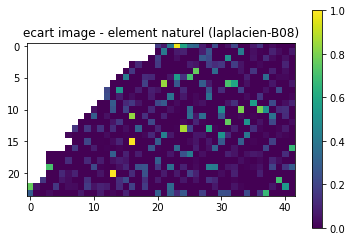

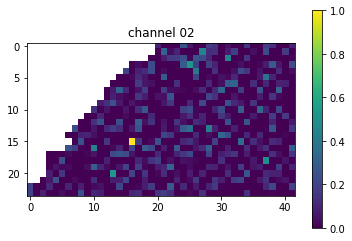

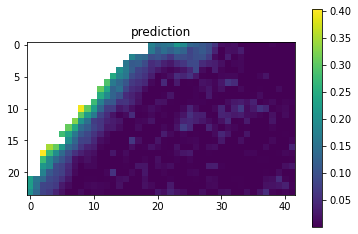

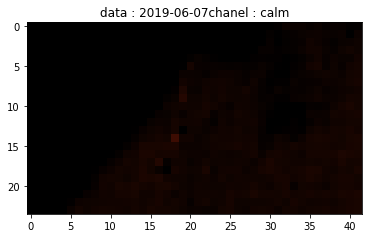

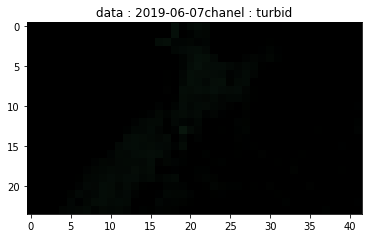

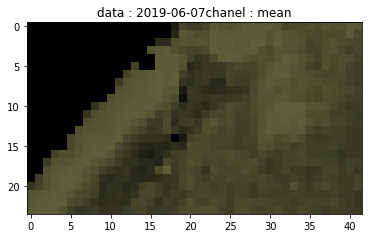

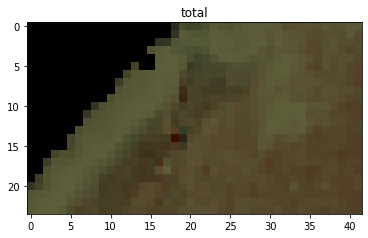

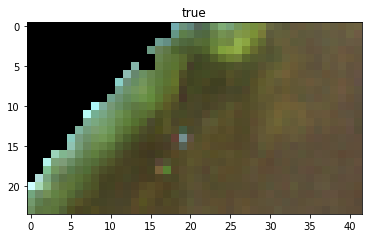

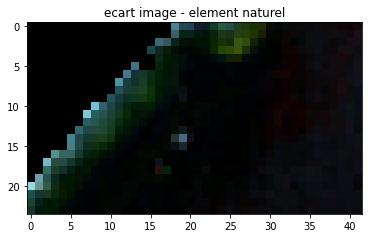

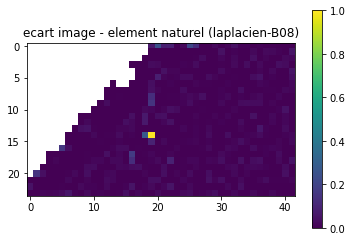

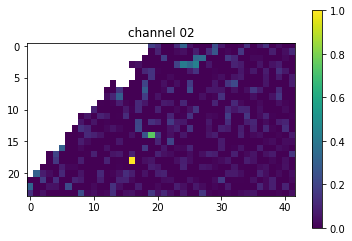

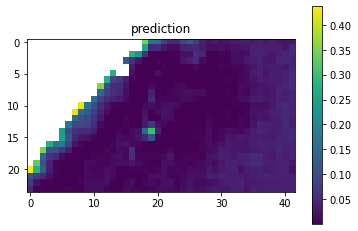

In [40]:
from pysptools.abundance_maps.amaps import FCLS
dic={0:"calm",1:"turbid",2:"mean",3:"algae",4: "plastic"}
shape=(len(data.x.unique()),len(data.y.unique()))
facteur=10
for i in data.index.unique(level=0):

    print(i)

    image=data.loc[i]

    target=image[["B02","B03","B04","B08"]].dropna()
    #spectral_sign=np.array([[0.028,0.006,0.001,0.0001],[0.007,0.018,0.011,0.001],[0.03,0.07,0.06,0.021]])
    spectral_sign=np.array([[0.028,0.006,0.001,0.0001],[0.007,0.018,0.011,0.0009],np.array(target.mean()),[ 0.1, 0.13, 0.19,0.23]])# sans turbide avec plastique -> moins de bruit pour ecart, mais pas d'assurance qu'on est sur du plastique. Cible plastique semble moins bruyant mais dés fois ont detecte pas u
    dic={0:"calm",1:"turbid",3: "plastic",2:"mean"} 
    #spectral_sign=np.array([[0.028,0.006,0.001,0.0001],[0.007,0.02,0.017,0.002],[0.03,0.07,0.06,0.021],[ 0.1, 0.13, 0.19,0.23]])#avec tout
    #dic={0:"calm",1:"turbid",2:"algae",3: "plastic"}
    #spectral_sign=np.array([[0.028,0.006,0.001,0.0001],[0.007,0.018,0.011,0.0009],np.array(target.mean()),[0.03,0.07,0.06,0.021],[ 0.1, 0.13, 0.19,0.23]])#avec tout
    #dic={0:"calm",1:"turbid",2:"mean",3:"algae",4: "plastic"}
    #spectral_sign=np.array([[0.032,0.007,0.001,0.0001],[0.009,0.022,0.015,0.0009],[0.03,0.07,0.06,0.021],[ 0.1, 0.13, 0.19,0.23]])#en augmentant un peu les valeurs de l'eau
    
    print(spectral_sign)
    resultat=FCLS(np.array(target),spectral_sign)
    total=np.zeros((shape[0],shape[1],4))
    
    
    for k in range(spectral_sign.shape[0]-1):
            
        plt.figure()
        plt.title("data : "+str(i)+"chanel : "+dic[k])
        data.loc[i,"prediction"]=np.array(pd.Series(resultat[:,k],index=target.index).reindex(image.index))
        im_pred=np.array(data.loc[i]["prediction"]).reshape(shape).astype(np.float64)
        to_plot=np.expand_dims(im_pred,axis=-1)*spectral_sign[k][0:3]#[spectral_sign[k][2],spectral_sign[k][1],spectral_sign[k][0]]
        total=total+np.expand_dims(im_pred,axis=-1)*spectral_sign[k]
        plt.imshow(to_plot*facteur)
    
    k=spectral_sign.shape[0]-1
    data.loc[i,"prediction"]=np.array(pd.Series(resultat[:,k],index=target.index).reindex(image.index))
    
    
    true=np.array(data.loc[i][["B02","B03","B04","B08"]]).reshape((shape[0],shape[1],4))
    ecart=true-total

    plt.figure()
    plt.title("total")
    to_plot=total[:,:,0:3]
    
    plt.imshow(to_plot*facteur)

    

    plt.figure()
    plt.title("true")
    
    to_plot=true[:,:,0:3]
    plt.imshow(to_plot*facteur)
    
    plt.figure()
    plt.title("ecart image - element naturel")
    
    to_plot=np.abs(ecart[:,:,0:3])
    plt.imshow(to_plot*facteur)


    plt.figure()
    plt.title("ecart image - element naturel (laplacien-B08)")
    
    to_plot=ecart[:,:,3]
    dst = cv.Laplacian(to_plot, -1)
    plt.imshow((dst<0)*dst/np.nanmin(dst))
    plt.colorbar()


    plt.figure()
    plt.title("channel 02")
    im_pred=np.array(data.loc[i]["B02"]).reshape((shape[0],shape[1])).astype(np.float64)
    dst = cv.Laplacian(im_pred, -1)
    plt.imshow((dst<0)*dst/np.nanmin(dst))
    plt.colorbar()

    plt.figure()
    plt.title("prediction")
    im_pred=np.array(data.loc[i]["prediction"]).reshape(shape).astype(np.float64)
    dst = cv.Laplacian(im_pred, -1)
    plt.imshow(im_pred)
    plt.colorbar()
    
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.08825898630633888

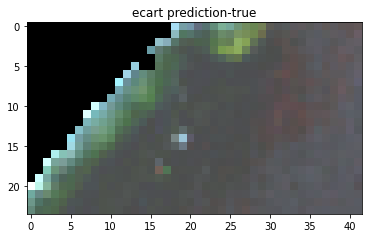

In [49]:
plt.imshow(np.abs(ecart[:,:,0:3])/np.nanmax(np.abs(ecart[:,:,0:3]))+0.3)
plt.title("ecart prediction-true")
np.nanmax(np.abs(ecart[:,:,0:3]))

In [25]:
np.abs(ecart[:,30:40,:])*facteur

array([[[4.35966807e-02, 4.02136551e-02, 2.36535129e-02, 3.68885503e-02],
        [1.45541507e-02, 1.04403447e-02, 2.25306717e-02, 4.59267859e-02],
        [6.51920689e-03, 2.23821188e-02, 2.42112609e-03, 3.86334904e-02],
        [2.71670859e-02, 2.06585655e-02, 1.56365315e-02, 3.01317893e-02],
        [3.60106465e-02, 1.81800690e-02, 1.10484085e-02, 3.57575292e-02],
        [2.46758280e-02, 1.95620991e-03, 1.22406454e-02, 5.04513942e-02],
        [3.22493857e-02, 1.06710256e-02, 2.94132049e-02, 4.70604199e-02],
        [4.86524430e-02, 1.04143106e-02, 1.90762939e-02, 5.37858898e-02],
        [3.22368605e-02, 7.54652265e-04, 2.71042310e-02, 5.26709873e-02],
        [4.11614136e-02, 7.99868802e-03, 6.63425527e-03, 3.36830790e-02]],

       [[5.39099013e-04, 9.32619013e-03, 7.71685769e-03, 2.23730762e-02],
        [1.84162505e-02, 9.31773382e-03, 4.28380087e-03, 3.25085272e-02],
        [1.84275431e-02, 6.54828732e-04, 3.16259049e-03, 4.15432608e-02],
        [3.60118902e-02, 1.07184282e